In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
from functools import partial

from CoupledQuantumSystems.noise import second_order_derivative,get_frequency,diel_spectral_density,one_over_f_spectral_density,T_phi

In [19]:
def second_order_derivative(f, x0, rtol=1e-3, atol=1e-4, max_iter=20):
    h = 1e-3
    derivative_old = 0.0
    print('\n')
    for i in range(max_iter):
        h /= 2
        derivative_new = (f(x0 + h) - 2 * f(x0) + f(x0 - h)) / h**2
        print(derivative_new)
        if np.abs(derivative_new - derivative_old) < rtol*np.abs(derivative_old):
            return derivative_new
        derivative_old = derivative_new
    raise ValueError("Convergence not reached within the maximum number of iterations")

def first_order_derivative(f, x0, rtol=1e-3, atol=1e-4, max_iter=20):
    h = 1e-3
    derivative_old = 0.0
    print('\n')
    for i in range(max_iter):
        h /= 2
        derivative_new = (f(x0 + h) - f(x0 - h)) / (2 * h)
        print(derivative_new)
        if np.abs(derivative_new - derivative_old) < rtol * np.abs(derivative_old):
            return derivative_new
        derivative_old = derivative_new
    raise ValueError("Convergence not reached within the maximum number of iterations")


def get_frequency(flux,EJ,EC,EL,i,j):
    qbt = scqubits.Fluxonium(EJ = EJ,EC = EC,EL =EL, cutoff = 110,flux = flux,truncated_dim=20)
    vals = qbt.eigenvals()
    return np.abs(vals[j]-vals[i])


hbar = 1/(2*np.pi)
kB = 8.617333262e-5  # eV K−1
hbar_in_eVs = 6.5821e-16  # eV s
temp_in_mK = 20

def diel_spectral_density(omega, EC,temp_in_mK = 20 ,Q_cap = 1e5):
    beta = 1 / (kB * temp_in_mK * 1e-3)  # 1/eV

    x = beta * hbar_in_eVs * omega # s GHZ
    x *= 1e9  # dimensionless
    return_val = 1/2 * np.abs( 1 / np.tanh(x/ 2) + 1) 

    return_val *= hbar * np.abs(omega)**2   / (4 * EC * Q_cap)  # GHZ^2/GHZ = GHZ
    return return_val

def one_over_f_spectral_density(omega, EL,one_over_f_flux_noise_amplitude ):
    return_val = 2 * np.pi # dimensionless
    return_val *= (EL / hbar)**2  # GHz^2
    return_val *= one_over_f_flux_noise_amplitude**2  # GHz^2
    return_val /= omega  # GHz
    return np.abs(return_val)

def T_phi(second_order_derivative, one_over_f_flux_noise_amplitude, first_order_derivative= 0 ):  # eqn (13) of Peter Groszkowski et al 2018 New J. Phys. 20 043053
    omega_uv = 3 * 2 * np.pi  # GHz
    omega_ir = 1e-9 * 2 * np.pi  # GHz
    t = 10e3  # ns
    A = one_over_f_flux_noise_amplitude  # in unit of Phi0

    first_order_part = 2 * A**2 * first_order_derivative**2
    first_order_part *= np.abs(np.log(omega_ir * t))

    second_order_part = 2 * A**4 * second_order_derivative**2  # Phi0^4 GHZ^2 / Phi0^4
    second_order_part *= (np.log(omega_uv / omega_ir)**2 + 2 * np.log(omega_ir * t)**2)  # GHZ^2
    return (first_order_part + second_order_part)  **(-1/2)  # ns

In [14]:
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6
temp_in_mK = 20

UIFQ_diel_T1_array = []
UIFQ_1overf_T1_array = []
UIFQ_T1_array = []
gf_Tphi_array = []
derivative_array = []

def get_data(EJoverEC):
    EJ = 4
    EJoverEL = 45
    EC = EJ / EJoverEC
    EL = EJ / EJoverEL

    UIFQ = scqubits.Fluxonium(EJ = EJ,EC = EJ/EJoverEC,EL = EJ/EJoverEL, cutoff =110,flux = 0,truncated_dim=20)
    UIFQ_element = np.abs(UIFQ.matrixelement_table('phi_operator',evals_count=3)[1,2]) 
    UIFQ_freq = (UIFQ.eigenvals()[2]-UIFQ.eigenvals()[1]) * 2 * np.pi
    gf_derivative = second_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=0,j=2),x0=0)

    UIFQ_dielectric_lifetime = 1 / (np.abs(UIFQ_element)**2 * diel_spectral_density(UIFQ_freq, EC,temp_in_mK,Q_cap)) / 1e6
    UIFQ_one_over_f_loss_lifetime = 1 / (np.abs(UIFQ_element)**2 * one_over_f_spectral_density(UIFQ_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    gf_dephasing_lifetime = T_phi(gf_derivative, one_over_f_flux_noise_amplitude) / 1e6

    return UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, gf_dephasing_lifetime, gf_derivative

for EJoverEC in tqdm(np.linspace(1,8,100),desc='looping'):
    UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, gf_dephasing_lifetime, gf_derivative = get_data(EJoverEC)
    UIFQ_T1 =1/(1/UIFQ_dielectric_lifetime + 1/UIFQ_one_over_f_loss_lifetime)

    UIFQ_diel_T1_array.append(UIFQ_dielectric_lifetime)
    UIFQ_1overf_T1_array.append(UIFQ_one_over_f_loss_lifetime)
    UIFQ_T1_array.append(UIFQ_T1)
    gf_Tphi_array.append(gf_dephasing_lifetime)
    derivative_array.append(gf_derivative)
    clear_output()

import pickle

# Create a dictionary to store the lists
data_to_store = {
    'UIFQ_diel_T1_array': UIFQ_diel_T1_array,
    'UIFQ_1overf_T1_array': UIFQ_1overf_T1_array,
    'UIFQ_T1_array': UIFQ_T1_array,
    'gf_Tphi_array': gf_Tphi_array,
    'derivative_array':derivative_array
}

# Save the dictionary to a pickle file
with open('gf-data.pkl', 'wb') as f:
    pickle.dump(data_to_store, f)

looping: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


In [15]:
import pickle

# Load the dictionary from the pickle file
with open('gf-data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract the lists from the dictionary
UIFQ_diel_T1_array = loaded_data['UIFQ_diel_T1_array']
UIFQ_1overf_T1_array = loaded_data['UIFQ_1overf_T1_array']
UIFQ_T1_array = loaded_data['UIFQ_T1_array']
gf_Tphi_array = loaded_data['gf_Tphi_array']
derivative_array = loaded_data['derivative_array']

In [21]:
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6


UIFQ_diel_T1_array_sweep_flux = []
UIFQ_1overf_T1_array_sweep_flux = []
UIFQ_T1_array_sweep_flux = []
gf_Tphi_array_sweep_flux = []
gf_diel_T1_array_sweep_flux = []
gf_1overf_T1_array_sweep_flux = []
gf_T1_array_sweep_flux = []

def get_data_sweep_flux(flux):
    EJ = 4
    EJoverEC = 2.7
    EJoverEL = 45
    EC = EJ / EJoverEC
    EL = EJ / EJoverEL

    IFQ = scqubits.Fluxonium(EJ = EJ,EC = EJ/EJoverEC,EL = EJ/EJoverEL, cutoff =110,flux = flux,truncated_dim=20)
    UIFQ_element = np.abs(IFQ.matrixelement_table('phi_operator',evals_count=3)[1,2]) 
    UIFQ_freq = (IFQ.eigenvals()[2]-IFQ.eigenvals()[1]) * 2 * np.pi
    UIFQ_dielectric_lifetime = 1 / (np.abs(UIFQ_element)**2 * diel_spectral_density(UIFQ_freq, EC,temp_in_mK,Q_cap)) / 1e6
    UIFQ_one_over_f_loss_lifetime = 1 / (np.abs(UIFQ_element)**2 * one_over_f_spectral_density(UIFQ_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    
    gf_1st_derivative = first_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=0,j=2),x0=flux)
    gf_2nd_derivative = second_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=0,j=2),x0=flux)
    gf_dephasing_lifetime = T_phi(gf_2nd_derivative, one_over_f_flux_noise_amplitude,gf_1st_derivative) / 1e6

    gf_element = np.abs(IFQ.matrixelement_table('phi_operator',evals_count=3)[0,2]) 
    gf_freq = (IFQ.eigenvals()[2]-IFQ.eigenvals()[0]) * 2 * np.pi
    gf_dielectric_lifetime = 1 / (np.abs(gf_element)**2 * diel_spectral_density(gf_freq, EC,temp_in_mK,Q_cap)) / 1e6
    gf_one_over_f_loss_lifetime = 1 / (np.abs(gf_element)**2 * one_over_f_spectral_density(gf_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6

    return UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, gf_dephasing_lifetime, gf_dielectric_lifetime, gf_one_over_f_loss_lifetime

flux_array = np.logspace(-6, -2, num=50)

for flux in tqdm(flux_array,desc='looping'):
    UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, gf_dephasing_lifetime, gf_dielectric_lifetime, gf_one_over_f_loss_lifetime = get_data_sweep_flux(flux)
    UIFQ_T1 = 1/(1/UIFQ_dielectric_lifetime + 1/UIFQ_one_over_f_loss_lifetime)
    gf_T1 = 1/(1/gf_dielectric_lifetime + 1/gf_one_over_f_loss_lifetime)
    UIFQ_diel_T1_array_sweep_flux.append(UIFQ_dielectric_lifetime)
    UIFQ_1overf_T1_array_sweep_flux.append(UIFQ_one_over_f_loss_lifetime)
    gf_diel_T1_array_sweep_flux.append(gf_dielectric_lifetime)
    gf_1overf_T1_array_sweep_flux.append(gf_one_over_f_loss_lifetime)
    UIFQ_T1_array_sweep_flux.append(UIFQ_T1)
    gf_T1_array_sweep_flux.append(gf_T1)
    gf_Tphi_array_sweep_flux.append(gf_dephasing_lifetime)
    clear_output()
    
import pickle

# Create a dictionary to store the lists
data_to_store = {
    'UIFQ_diel_T1_array_sweep_flux': UIFQ_diel_T1_array_sweep_flux,
    'UIFQ_1overf_T1_array_sweep_flux': UIFQ_1overf_T1_array_sweep_flux,
    'gf_diel_T1_array_sweep_flux': gf_diel_T1_array_sweep_flux,
    'gf_1overf_T1_array_sweep_flux': gf_1overf_T1_array_sweep_flux,
    'UIFQ_T1_array_sweep_flux':UIFQ_T1_array_sweep_flux,
    'gf_T1_array_sweep_flux':gf_T1_array_sweep_flux,
    'gf_Tphi_array_sweep_flux':gf_Tphi_array_sweep_flux,

}

# Save the dictionary to a pickle file
with open('gf-data_sweep_flux.pkl', 'wb') as f:
    pickle.dump(data_to_store, f)

looping: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


In [22]:
import pickle

# Load the dictionary from the pickle file
with open('gf-data_sweep_flux.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract the lists from the dictionary
UIFQ_diel_T1_array_sweep_flux = loaded_data['UIFQ_diel_T1_array_sweep_flux']
UIFQ_1overf_T1_array_sweep_flux = loaded_data['UIFQ_1overf_T1_array_sweep_flux']
gf_diel_T1_array_sweep_flux = loaded_data['gf_diel_T1_array_sweep_flux']
gf_1overf_T1_array_sweep_flux = loaded_data['gf_1overf_T1_array_sweep_flux']
UIFQ_T1_array_sweep_flux = loaded_data['UIFQ_T1_array_sweep_flux']
gf_T1_array_sweep_flux = loaded_data['gf_T1_array_sweep_flux']
gf_Tphi_array_sweep_flux = loaded_data['gf_Tphi_array_sweep_flux']

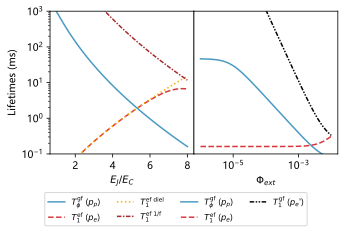

In [46]:
fig = plt.figure(figsize=(5, 3.2)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0.15, right=0.55,bottom=0.35,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=0.55, right=0.95,bottom=0.35,top = 0.97)


################################################
#
#   subplot 1 
#
################################################
ax = fig.add_subplot(gs0[0])


ax.plot(np.linspace(1,8,100), gf_Tphi_array, color= '#4999c3',label = rf'$T_\phi^\text{{gf}}$ ($p_p$)',linestyle='-')
ax.plot(np.linspace(1,8,100), UIFQ_T1_array, color= '#d5373d',label = rf'$T_1^\text{{ef}}$ ($p_e$)',linestyle='--')

ax.plot(np.linspace(1,8,100), UIFQ_diel_T1_array, color= 'orange',label = rf'$T_1^\text{{ef diel}}$',linestyle=':')
ax.plot(np.linspace(1,8,100), UIFQ_1overf_T1_array, color= 'brown',label = rf'$T_1^\text{{ef 1/f}}$',linestyle=(0,(3,1,1,1)))

ymin = 1e-1
ymax = 1e3
ax.set_ylim(ymin, ymax)

# ax2 = ax.twinx()
# ax2.set_ylabel(r'$p$')
# ax2.set_ylim(1e-3/ymin,1e-3/ymax)
# ax2.set_yscale('log')

ax.set_yscale('log')
ax.set_xlabel(r'$E_J/E_C$')
ax.set_ylabel(r'Lifetimes (ms)')
# ax.legend(ncol = 2,loc='upper right')

handles1, labels1 = ax.get_legend_handles_labels()

################################################
#
#   subplot 2
#
################################################

ax = fig.add_subplot(gs1[0])

ax.plot( flux_array, gf_Tphi_array_sweep_flux, color= '#4999c3',label = rf'$T_\phi^\text{{gf}}$ ($p_p$)',linestyle='-')
ax.plot( flux_array, UIFQ_T1_array_sweep_flux, color= '#d5373d',label = rf'$T_1^\text{{ef}}$ ($p_e$)',linestyle='--')
ax.plot( flux_array, gf_T1_array_sweep_flux, color= 'black',label = rf"$T_1^\text{{gf}}$ ($p_e$')",linestyle=(0,(3,1,1,1,1,1)))

ymin = 1e-1
ymax = 1e3
ax.set_ylim(ymin, ymax)

# ax2 = ax.twinx()
# ax2.set_ylabel(r'$p$')
# ax2.set_ylim(1e-3/ymin,1e-3/ymax)
# ax2.set_yscale('log')

# y_ticks_lifetimes = ax.get_yticks()
# secax_y = ax.secondary_yaxis('right')
# secax_y.set_ylabel(r'$p_e$')
# secax_y.set_yticks(y_ticks_lifetimes,labels=[f'{1e-3 * val:.2e}' for val in y_ticks_lifetimes])

# ax2.set_yticks(y_ticks_lifetimes,labels=[f'{1e-3 / val:.2e}' for val in y_ticks_lifetimes])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Phi_{ext}$')
ax.set_ylabel(r'Lifetimes (ms)')
# ax.legend(ncol = 2,loc='upper right')

ax.get_yaxis().set_visible(False)


handles2, labels2 = ax.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a legend using both sets of handles and labels
fig.legend(handles, labels, loc='lower center',ncol = 4, fontsize='small', bbox_to_anchor=(0.5, 0.02))

fig.savefig('gf_lifetimes_small.pdf')

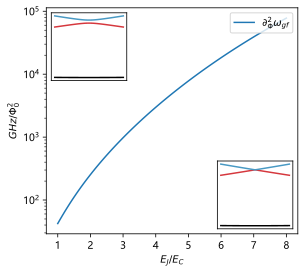

In [4]:
import numpy as np
import scqubits
import matplotlib.pyplot as plt
EJ = 3
EJoverEL = 30
EL = EJ / EJoverEL


fluxonium_light = scqubits.Fluxonium(
    EJ=EJ,
    EC= EJ / 2,
    EL=EL,
    cutoff = 110,
    flux = 0
)


fluxonium_heavy = scqubits.Fluxonium(
    EJ=EJ,
    EC= EJ / 7,
    EL=EL,
    cutoff = 110,
    flux = 0
)

flux_list = np.linspace(-0.05, 0.05, 51)

# light_specdata = fluxonium_light.get_spectrum_vs_paramvals(
#     'flux',
#     flux_list,
#     evals_count=3,
#     subtract_ground=False,
#     # num_cpus=6,
# )
# heavt_specdata = fluxonium_heavy.get_spectrum_vs_paramvals(
#     'flux',
#     flux_list,
#     evals_count=3,
#     subtract_ground=False,
#     # num_cpus=6,
# )

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(5, 3.7)) 
gs = fig.add_gridspec(nrows=1, ncols=1,left=0.15, right=0.85,bottom=0.12,top = 0.97)
ax = fig.add_subplot(gs[0])
ax.plot(np.linspace(1,8,100), derivative_array,label = rf'$\partial_\Phi^2 \omega_{{gf}}$')


inset_a = inset_axes(ax, width="30%", height="30%", loc='lower right')
for arr,color in zip( heavt_specdata.energy_table.T,
                     ['black',  '#d5373d','#4999c3']):
    inset_a.plot(flux_list,arr,color=color)
inset_a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


inset_b = inset_axes(ax, width="30%", height="30%", loc='upper left')
for arr,color in zip(light_specdata.energy_table.T,
                     ['black',  '#d5373d','#4999c3']):
    inset_b.plot(flux_list,arr,color=color)
inset_b.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

ax.set_yscale('log')
ax.set_xlabel(r'$E_J/E_C$')
ax.set_ylabel(r'$GHz/\Phi_0^2$')
ax.legend(ncol = 2,loc='upper right')
fig.savefig('gf_curvature.pdf')

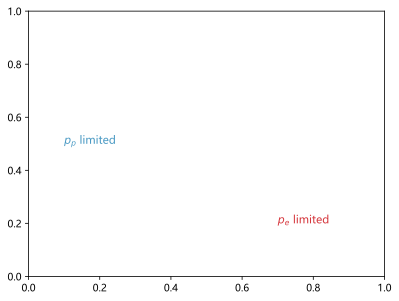

In [5]:
plt.text(0.1,0.5,r'$p_p$ limited',color= '#4999c3',size = 11)

plt.text(0.7,0.2,r'$p_e$ limited',color= '#d5373d',size = 11)

plt.savefig('text.pdf')

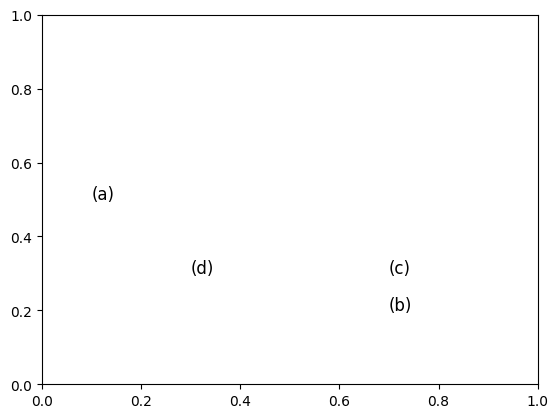

In [1]:

import matplotlib.pyplot as plt

plt.text(0.1,0.5,'(a)',color= 'black',size = 12)

plt.text(0.7,0.2,'(b)',color= 'black',size = 12)

plt.text(0.7,0.3,'(c)',color= 'black',size = 12)

plt.text(0.3,0.3,'(d)',color= 'black',size = 12)

plt.savefig('text1.pdf')